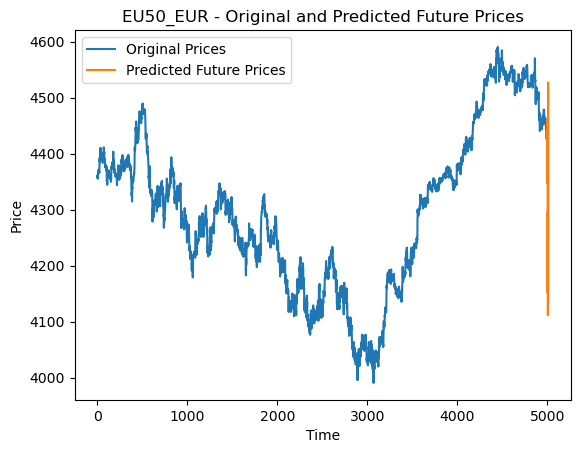

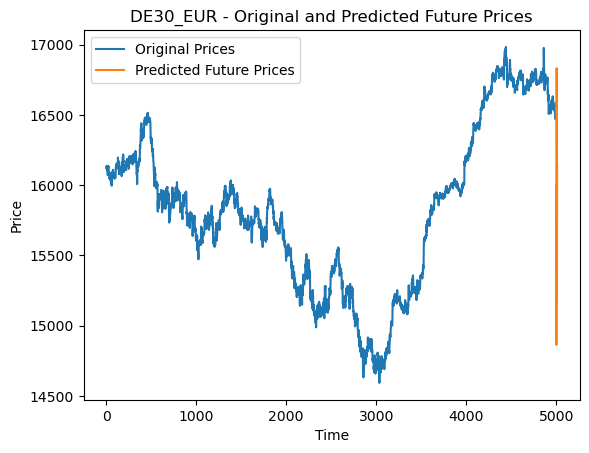

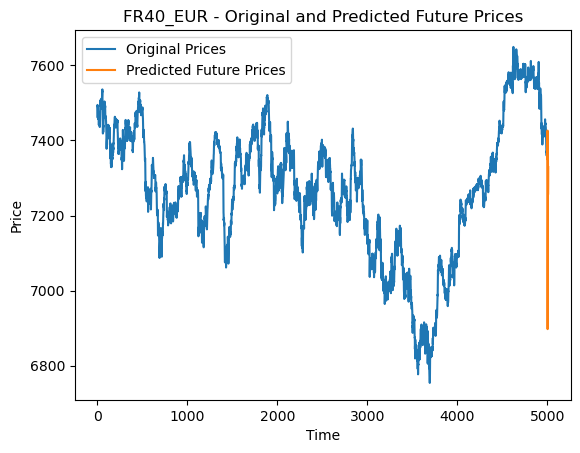

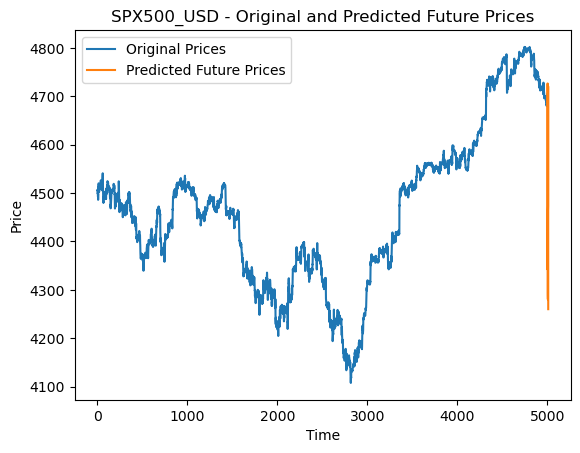

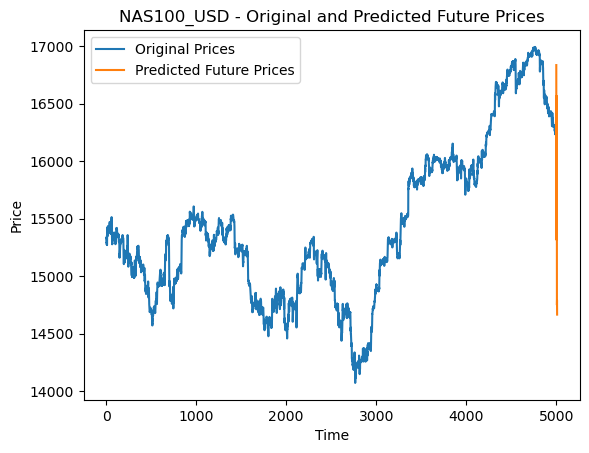

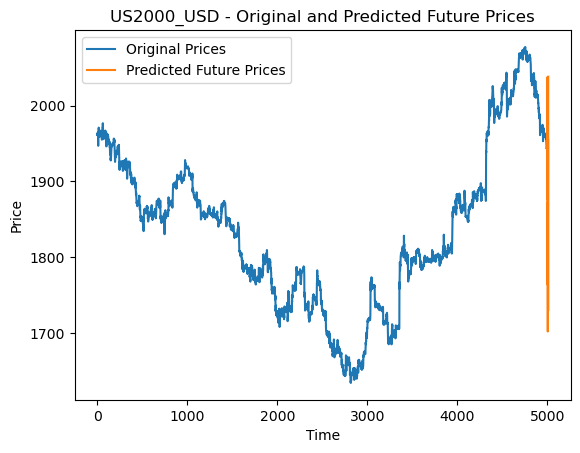

In [1]:
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity


# Function to retrieve historical OANDA data
def get_oanda_data(client, symbol, count, granularity):
    params = {
        "count": count,
        "granularity": granularity
    }
    request = instruments.InstrumentsCandles(instrument=symbol, params=params)
    client.request(request)
    response = request.response

    candles = response["candles"]
    prices = [float(candle["mid"]["c"]) for candle in candles]

    return prices

# Function to retrieve OANDA data for multiple symbols
def get_funds_data(client, symbols, count, granularity):
    funds_data = {}
    for symbol in symbols:
        prices = get_oanda_data(client, symbol, count, granularity)
        funds_data[symbol] = {'Close': prices}
    return funds_data

# Define OANDA symbols to consider
symbols = [
    'EU50_EUR',
    'DE30_EUR',
    'FR40_EUR',
    'SPX500_USD',
    'NAS100_USD', 
    'US2000_USD',


]

# Initialize OANDA connection
access_token = "e11aadc917842adf254cd73c038c4e0a-321ea21ac5697ab46036807f5e5e943d"
client = API(access_token=access_token)

# Retrieve historical OANDA data
count = 5000
granularity = "M30"
funds_data = get_funds_data(client, symbols, count, granularity)

# Convert data to numpy arrays
prices_arrays = {}
for symbol in symbols:
    prices = funds_data[symbol]['Close']
    prices_arrays[symbol] = np.asarray(prices)

# Create a graph representation of the financial relationships
G = nx.Graph()
for symbol in prices_arrays:
    G.add_node(symbol)

    # Add edges based on correlation coefficient
    for other_symbol in prices_arrays:
        if symbol != other_symbol:
            correlation = np.corrcoef(prices_arrays[symbol], prices_arrays[other_symbol])[0, 1]

            if abs(correlation) >= 0.5:
                G.add_edge(symbol, other_symbol, correlation=correlation)

# Adjust the bandwidth based on graph correlations
def get_bandwidth(symbol, graph):
    neighbors = list(graph.neighbors(symbol))
    if not neighbors:
        return 0.1  # default bandwidth if no neighbors

    # Use the average correlation coefficient of neighbors to adjust bandwidth
    avg_correlation = np.mean([graph[symbol][neighbor]['correlation'] for neighbor in neighbors])
    bandwidth = 0.1 * (1 + avg_correlation)  # adjust the factor based on your preference

    return bandwidth

# Apply a particle filter to predict future price movements
for symbol in prices_arrays:
    pf = KernelDensity(bandwidth=get_bandwidth(symbol, G))
    
    # Reshape the data to 2D array
    data_2d = prices_arrays[symbol].reshape(-1, 1)
    
    pf.fit(data_2d)

    # Predict future price movements
    future_prices = pf.sample(10)
    
    # Plot the original prices and predicted future prices
    plt.plot(np.arange(len(prices_arrays[symbol])), prices_arrays[symbol], label='Original Prices')
    plt.plot(np.arange(len(prices_arrays[symbol]), len(prices_arrays[symbol]) + len(future_prices)), future_prices, label='Predicted Future Prices')
    
    plt.title(f"{symbol} - Original and Predicted Future Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
